<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Recovered - Death Rate - Reproduction Number (R)

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData




Set the list of countries we want to take a look at:

In [29]:
# selected_countries = ['Argentina', 'Spain', 'Italy', 'Brazil', 'Chile', 
#                        'Germany', 'US', 'France', 'United Kingdom']

selected_countries = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 
                      'Mexico', 'Peru']


First: Download the Johns Hopkins CSSE global dataset for Covid-19:

In [30]:
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  235k  100  235k    0     0   596k      0 --:--:-- --:--:-- --:--:--  596k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  166k  100  166k    0     0   512k      0 --:--:-- --:--:-- --:--:--  510k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207k  100  207k    0     0   504k      0 --:--:-- --:--:-- --:--:--  504k


Next: Import the libraries we will use for data wrangling and display:

In [31]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [40, 20]
import numpy as np
import pandas as pd

Load the downloaded dataset (csv files) into [Pandas](https://pandas.pydata.org/) dataframes and remove columns we do not need:

In [32]:
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
                           error_bad_lines=False)

Define helper functions

In [33]:
# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()
    selected_df.set_index('Country/Region', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values
    diff_df[diff_df < 0] = 0
    return diff_df
     

## Create dataframe with selected countries and new confirmed cases per day

In [34]:
selected_confirmed_df = get_selected_countries(confirmed_df)
new_confirmed_df = get_difference_between_days(selected_confirmed_df)
new_confirmed_df

,2020-02-23,2020-02-26,2020-02-28,2020-02-29,2020-03-01,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,...,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,5.0,2.0,0.0,12.0,3.0,11.0,11.0,12.0,11.0,18.0,31.0,30.0,108.0,35.0,86.0,0.0,115.0,87.0,101.0,55.0,75.0,234.0,0.0,79.0,132.0,186.0,0.0,103.0,...,6127.0,5493.0,4814.0,4192.0,4890.0,5939.0,5641.0,6377.0,5929.0,5241.0,5376.0,4824.0,6792.0,7147.0,7513.0,7482.0,6134.0,4688.0,7369.0,7043.0,7663.0,7498.0,6365.0,6663.0,5469.0,4557.0,6840.0,6693.0,8225.0,8159.0,7759.0,5352.0,8713.0,8771.0,10550.0,10104.0,11717.0,9230.0,7187.0,9309.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,7.0,0.0,1.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,2.0,3.0,11.0,18.0,13.0,7.0,16.0,10.0,8.0,8.0,9.0,7.0,18.0,26.0,...,1117.0,1204.0,1825.0,1148.0,1752.0,1146.0,1207.0,1700.0,1555.0,2004.0,1360.0,1693.0,1515.0,1780.0,1282.0,1468.0,1164.0,944.0,1636.0,1693.0,1743.0,1388.0,1491.0,1196.0,1198.0,879.0,1796.0,2031.0,1015.0,1370.0,992.0,722.0,999.0,851.0,1095.0,1035.0,1280.0,945.0,614.0,630.0
Brazil,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,9.0,0.0,7.0,5.0,6.0,7.0,14.0,99.0,0.0,11.0,38.0,121.0,51.0,249.0,172.0,228.0,525.0,378.0,323.0,307.0,431.0,432.0,487.0,352.0,323.0,1138.0,1119.0,1208.0,1012.0,1304.0,770.0,1031.0,...,59961.0,55891.0,51147.0,24578.0,23284.0,40816.0,69074.0,57837.0,52383.0,45392.0,25800.0,16641.0,51603.0,57152.0,53139.0,50230.0,49970.0,23010.0,22048.0,52160.0,55155.0,60091.0,50644.0,41576.0,23101.0,19373.0,47784.0,49298.0,45323.0,30355.0,50032.0,23421.0,17078.0,47134.0,47161.0,44235.0,43412.0,41350.0,16158.0,45961.0
Chile,2.0,0.0,0.0,0.0,7.0,1.0,0.0,3.0,0.0,0.0,7.0,0.0,5.0,10.0,0.0,20.0,33.0,13.0,81.0,46.0,37.0,0.0,196.0,131.0,95.0,114.0,176.0,220.0,164.0,304.0,350.0,230.0,310.0,289.0,293.0,373.0,333.0,512.0,310.0,344.0,...,2357.0,2545.0,2288.0,2198.0,2133.0,1877.0,1775.0,1961.0,2131.0,1991.0,2073.0,1762.0,1469.0,1761.0,1948.0,2154.0,2198.0,2033.0,1988.0,1572.0,1552.0,1866.0,2077.0,1791.0,2044.0,1556.0,1353.0,1182.0,1812.0,1920.0,1939.0,1957.0,1903.0,1417.0,1380.0,1737.0,1870.0,2037.0,1965.0,1752.0
Colombia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,4.0,9.0,12.0,23.0,18.0,27.0,6.0,50.0,38.0,35.0,46.0,101.0,92.0,21.0,48.0,69.0,94.0,96.0,108.0,159.0,96.0,106.0,139.0,79.0,94.0,...,7945.0,7168.0,7254.0,8181.0,8125.0,10284.0,8670.0,9965.0,9488.0,10673.0,11470.0,10199.0,7129.0,10735.0,11996.0,9494.0,9666.0,10611.0,10142.0,12830.0,12066.0,11286.0,11306.0,11578.0,11643.0,8328.0,12462.0,13056.0,11541.0,8419.0,0.0,19001.0,10549.0,10425.0,10130.0,9752.0,8497.0,9392.0,8020.0,7190.0
Mexico,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,14.0,15.0,12.0,29.0,11.0,25.0,46.0,39.0,48.0,65.0,51.0,38.0,70.0,110.0,132.0,131.0,145.0,101.0,121.0,163.0,132.0,178.0,202.0,253.0,296.0,...,8438.0,7573.0,6751.0,5480.0,4973.0,7208.0,5752.0,7730.0,8458.0,9556.0,4853.0,4767.0,6148.0,6139.0,6590.0,6717.0,6495.0,4376.0,5558.0,6686.0,5858.0,7371.0,5618.0,6345.0,4448.0,3571.0,5506.0,5792.0,6775.0,5928.0,6482.0,3948.0,3541.0,4916.0,5267.0,6026.0,5824.0,5974.0,4129.0,3719.0
Peru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,0.0,4.0

## Plot new confirmed cases per day

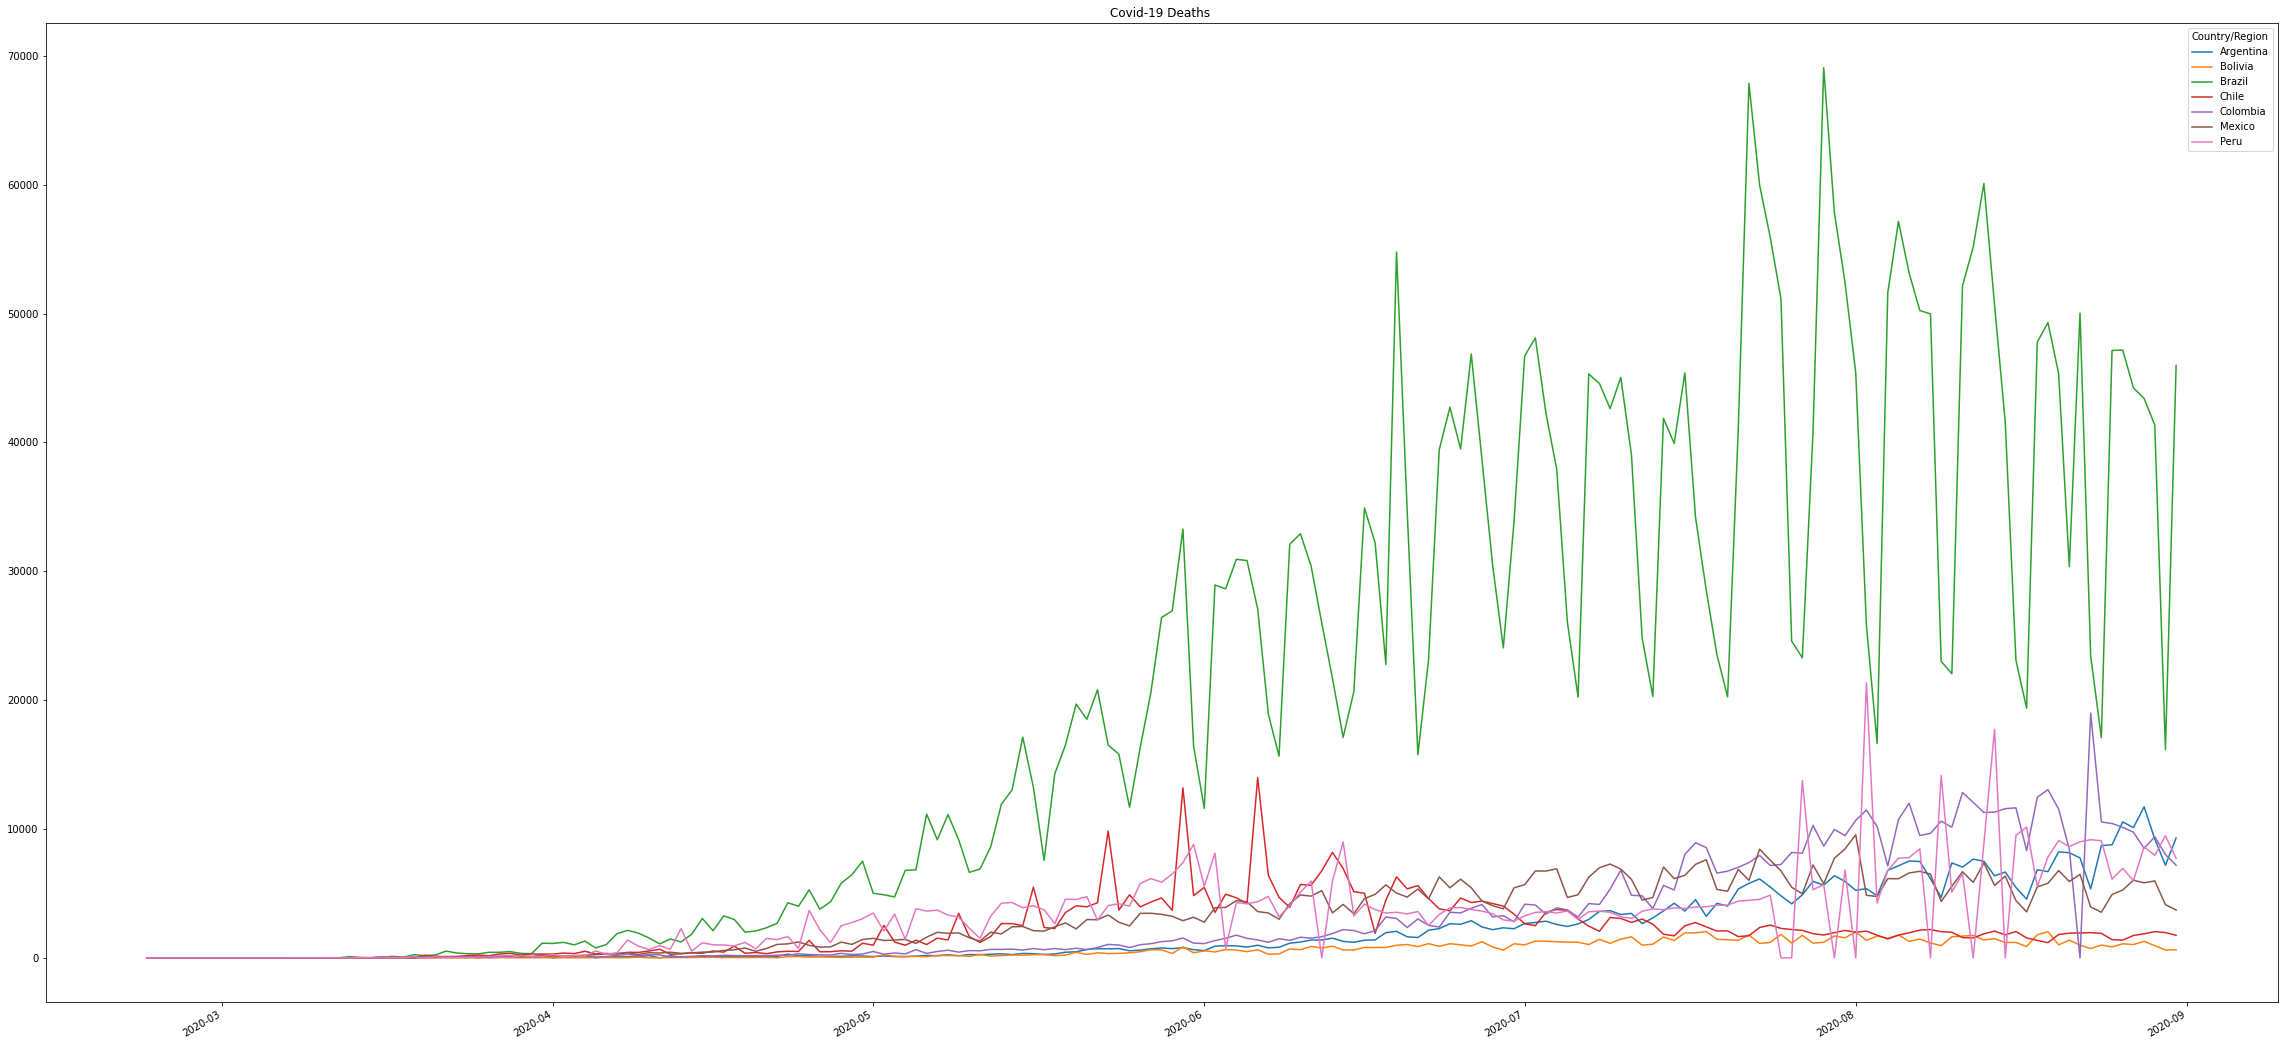

In [35]:
new_confirmed_df.transpose().plot(kind='line', title='Covid-19 Deaths ', 
                                  logy=False)

## Create dataframe with selected countries and number of deaths per day

In [36]:
selected_deaths_df = get_selected_countries(deaths_df)
new_deaths_df = get_difference_between_days(selected_deaths_df)
new_deaths_df

,2020-03-08,2020-03-13,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,...,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,4.0,1.0,8.0,3.0,4.0,1.0,4.0,8.0,7.0,9.0,10.0,1.0,7.0,7.0,5.0,9.0,4.0,8.0,6.0,3.0,4.0,11.0,5.0,13.0,...,114.0,105.0,86.0,46.0,120.0,120.0,109.0,153.0,102.0,53.0,52.0,165.0,166.0,127.0,145.0,160.0,112.0,83.0,158.0,240.0,209.0,149.0,165.0,110.0,66.0,111.0,234.0,282.0,187.0,213.0,118.0,137.0,381.0,197.0,276.0,211.0,221.0,82.0,104.0,203.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,4.0,3.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,3.0,6.0,...,79.0,66.0,62.0,48.0,64.0,73.0,88.0,86.0,83.0,87.0,89.0,75.0,92.0,65.0,80.0,59.0,63.0,53.0,72.0,49.0,66.0,57.0,55.0,64.0,55.0,65.0,49.0,61.0,72.0,61.0,76.0,67.0,69.0,86.0,62.0,65.0,55.0,92.0,28.0,61.0
Brazil,0.0,0.0,1.0,2.0,3.0,5.0,4.0,10.0,9.0,12.0,13.0,18.0,15.0,19.0,25.0,23.0,42.0,39.0,84.0,35.0,86.0,41.0,78.0,122.0,133.0,131.0,107.0,67.0,99.0,105.0,204.0,204.0,188.0,217.0,213.0,108.0,125.0,154.0,165.0,425.0,...,1311.0,1156.0,1211.0,555.0,614.0,921.0,1595.0,1129.0,1212.0,1088.0,541.0,561.0,1154.0,1437.0,1237.0,1079.0,905.0,572.0,703.0,1274.0,1175.0,1262.0,1060.0,709.0,620.0,684.0,1352.0,1212.0,1204.0,1054.0,892.0,494.0,565.0,1271.0,1085.0,984.0,855.0,758.0,566.0,553.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,2.0,4.0,5.0,7.0,3.0,6.0,5.0,9.0,8.0,8.0,7.0,2.0,10.0,2.0,11.0,11.0,10.0,7.0,6.0,8.0,13.0,8.0,...,116.0,76.0,106.0,92.0,75.0,53.0,38.0,99.0,80.0,76.0,75.0,99.0,38.0,47.0,97.0,69.0,53.0,66.0,62.0,39.0,27.0,94.0,41.0,55.0,57.0,61.0,33.0,32.0,93.0,52.0,69.0,60.0,64.0,42.0,32.0,82.0,60.0,49.0,63.0,45.0
Colombia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,4.0,2.0,4.0,1.0,2.0,6.0,7.0,3.0,11.0,4.0,4.0,15.0,11.0,20.0,9.0,3.0,15.0,4.0,13.0,9.0,13.0,13.0,10.0,7.0,10.0,9.0,...,315.0,287.0,294.0,256.0,252.0,297.0,380.0,356.0,295.0,225.0,320.0,367.0,298.0,309.0,315.0,311.0,290.0,302.0,312.0,321.0,362.0,308.0,347.0,318.0,287.0,275.0,247.0,360.0,204.0,385.0,0.0,748.0,296.0,277.0,295.0,283.0,299.0,297.0,300.0,299.0
Mexico,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,8.0,1.0,8.0,13.0,10.0,19.0,15.0,31.0,16.0,33.0,20.0,39.0,40.0,23.0,36.0,74.0,43.0,37.0,60.0,104.0,36.0,26.0,145.0,113.0,99.0,...,718.0,737.0,729.0,306.0,342.0,854.0,485.0,639.0,688.0,784.0,274.0,266.0,857.0,829.0,819.0,794.0,695.0,292.0,705.0,926.0,737.0,627.0,615.0,635.0,214.0,266.0,751.0,707.0,625.0,504.0,644.0,226.0,320.0,650.0,626.0,518.0,552.0,673.0,339.0,256.0
Peru,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,5.0,2.0,6.0,6.0,8.0,17.0,6.0,12.0,10.0,9.0,15.0,14.0,17.0,31.0,12.0,12.0,23.0,14.0,24.0,20.0,26.0,48.0,52.0,45.0,39.0,46.0,42.0,...,3887.0,189.0,0.0,0.0,575.0,194.0,204.0,0.0,205.0,0.0,593.0,197.0,196.0,221.0,196.0,225.0,0.0,423.0,204.0,225.0,0.0,212.0,4143.0,0.0,219.0,206.0,200.0,177.0,176.0,200.0,211.0,208.0,210.0,150.0,188.0,123.0,153.0,194.0,136.0,181.0


## Plot number of deaths per day

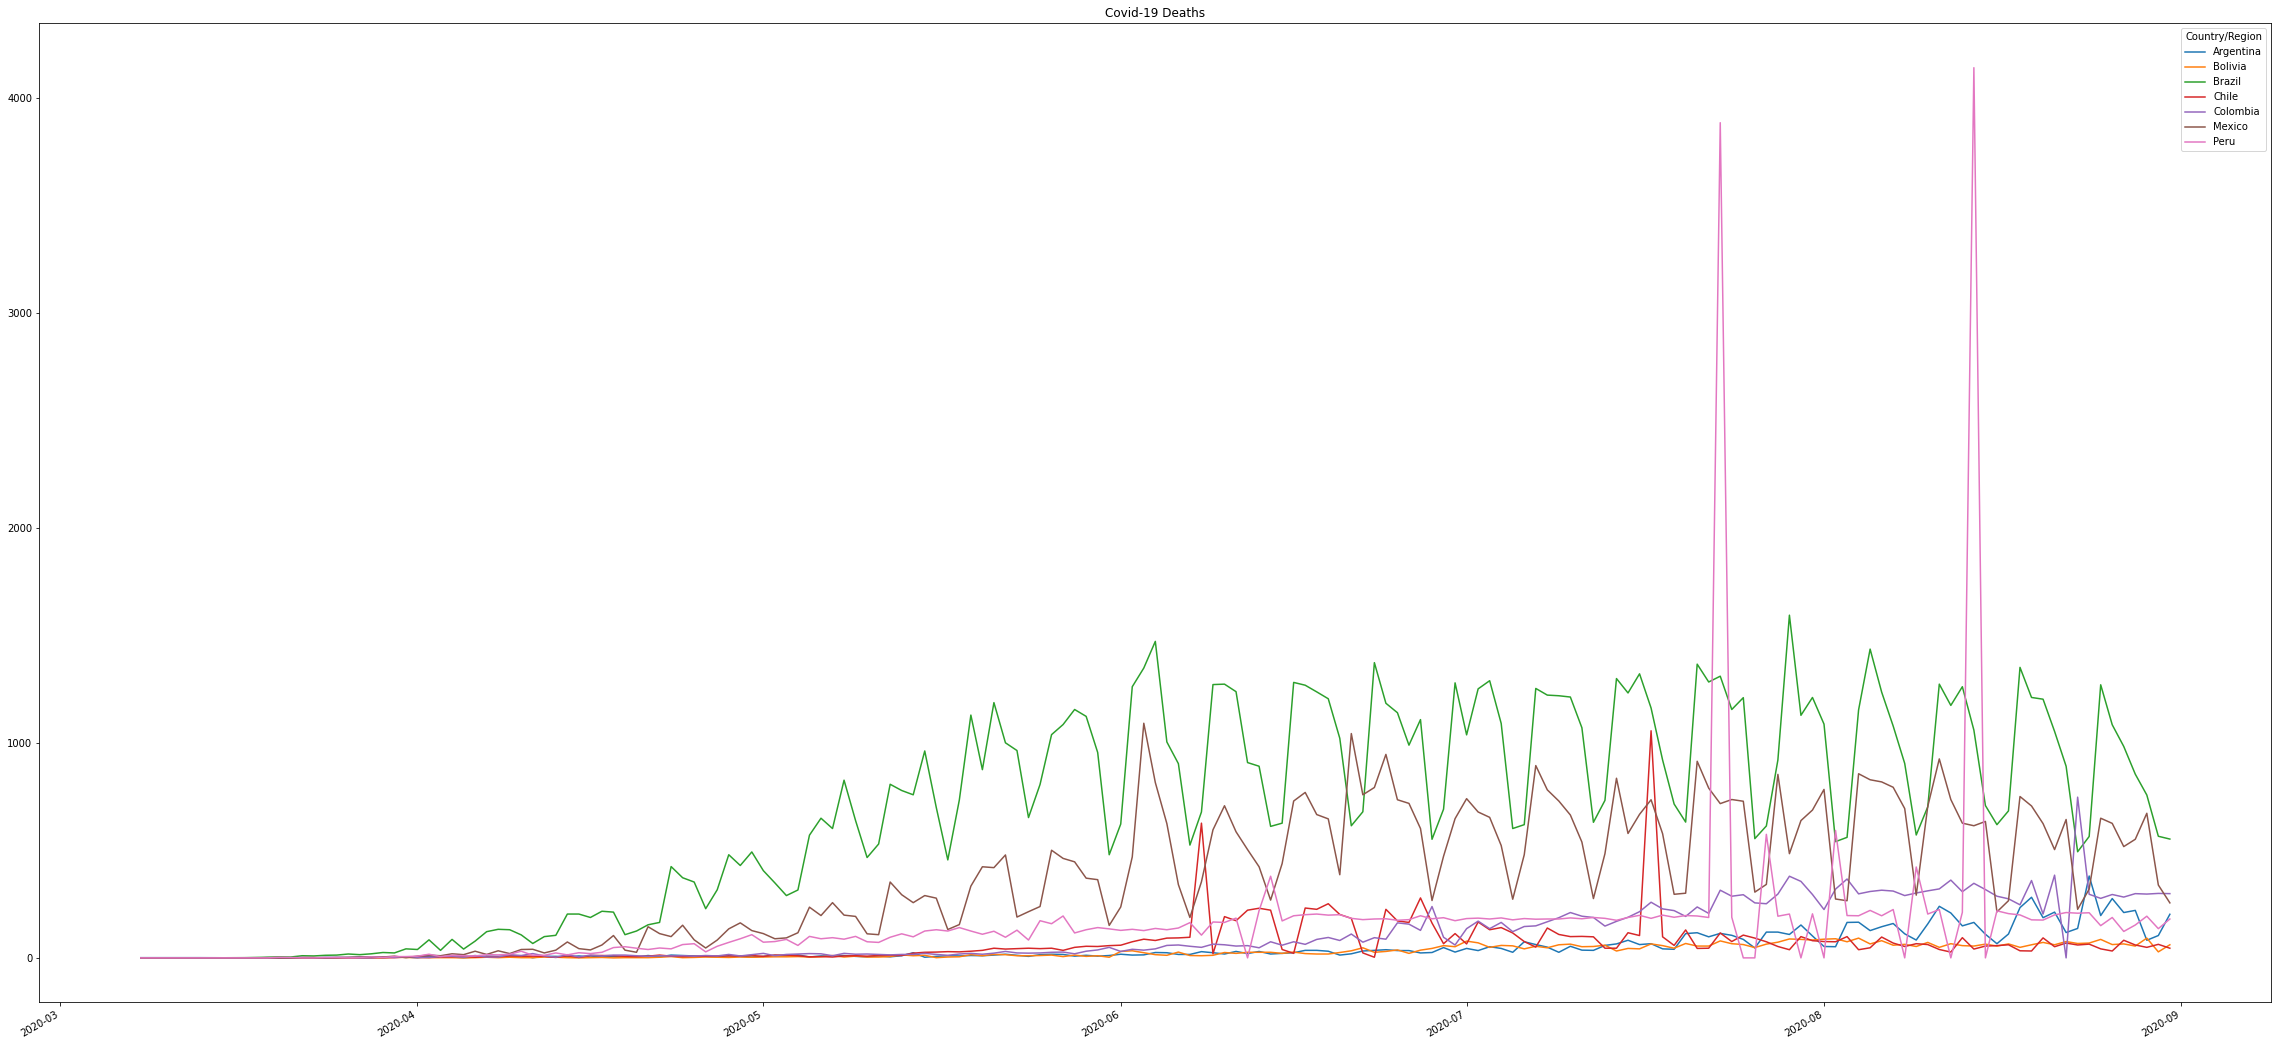

In [37]:
new_deaths_df.transpose().plot(kind='line', title='Covid-19 Deaths', logy=False)

## Create dataframe with selected countries and number of recovered patients per day

In [38]:
selected_recovered_df = get_selected_countries(recovered_df)
new_recovered_df = get_difference_between_days(selected_recovered_df)
new_recovered_df

,2020-03-03,2020-03-10,2020-03-14,2020-03-16,2020-03-17,2020-03-20,2020-03-22,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,...,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,1.0,0.0,2.0,0.0,0.0,49.0,0.0,11.0,9.0,0.0,0.0,156.0,12.0,8.0,8.0,10.0,13.0,1.0,45.0,13.0,20.0,7.0,10.0,65.0,28.0,47.0,44.0,37.0,35.0,35.0,19.0,24.0,28.0,103.0,32.0,47.0,57.0,54.0,...,2284.0,2632.0,2575.0,2496.0,2057.0,2508.0,2772.0,2741.0,3184.0,2719.0,2527.0,2276.0,2827.0,2819.0,2904.0,3445.0,4945.0,0.0,0.0,73147.0,5894.0,5151.0,6571.0,6692.0,6005.0,6148.0,5681.0,5194.0,4926.0,6155.0,5975.0,5619.0,5389.0,6413.0,5599.0,5657.0,5707.0,7055.0,6787.0,7188.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,7.0,12.0,5.0,0.0,0.0,6.0,7.0,0.0,10.0,0.0,...,309.0,584.0,337.0,218.0,309.0,493.0,535.0,799.0,277.0,386.0,188.0,354.0,880.0,1047.0,936.0,766.0,765.0,904.0,1015.0,930.0,1077.0,890.0,1003.0,915.0,853.0,980.0,1152.0,1342.0,1146.0,1030.0,1746.0,1509.0,1654.0,1825.0,1522.0,2124.0,2393.0,1835.0,1748.0,1911.0
Brazil,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,114.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,2873.0,10980.0,0.0,0.0,0.0,8104.0,0.0,861.0,2327.0,1255.0,1082.0,1505.0,...,28338.0,72901.0,92145.0,27554.0,33728.0,22108.0,54053.0,34005.0,52047.0,29128.0,24894.0,36100.0,58508.0,32877.0,40181.0,41757.0,49238.0,35446.0,33847.0,58508.0,56890.0,14872.0,95881.0,5897.0,32139.0,44063.0,52166.0,50685.0,42387.0,11240.0,58408.0,33818.0,28472.0,56295.0,49896.0,40399.0,35937.0,43402.0,35430.0,30976.0
Chile,0.0,0.0,0.0,0.0,0.0,6.0,2.0,9.0,5.0,0.0,21.0,18.0,14.0,81.0,0.0,78.0,101.0,92.0,101.0,90.0,110.0,170.0,217.0,159.0,297.0,293.0,195.0,308.0,279.0,291.0,362.0,322.0,414.0,303.0,338.0,293.0,417.0,418.0,523.0,419.0,...,2190.0,2265.0,2473.0,1926.0,1859.0,2378.0,2225.0,2071.0,1699.0,2180.0,1904.0,1565.0,2354.0,1961.0,1877.0,2000.0,1965.0,1693.0,1516.0,2199.0,1878.0,1712.0,1906.0,1914.0,1877.0,1557.0,2055.0,1845.0,1778.0,1834.0,1833.0,1449.0,1285.0,1999.0,1805.0,1654.0,1530.0,1731.0,1401.0,1295.0
Colombia,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,5.0,16.0,8.0,16.0,0.0,30.0,3.0,0.0,12.0,23.0,51.0,23.0,17.0,56.0,49.0,35.0,98.0,98.0,84.0,0.0,77.0,93.0,0.0,66.0,57.0,76.0,64.0,...,6338.0,5913.0,5803.0,5370.0,6124.0,5529.0,6087.0,5918.0,5692.0,6321.0,6531.0,6488.0,6531.0,6059.0,6038.0,6140.0,6096.0,8097.0,8796.0,8943.0,9358.0,10709.0,10799.0,13127.0,13016.0,14089.0,10798.0,13975.0,12826.0,9816.0,0.0,25084.0,10141.0,11298.0,11651.0,10667.0,11827.0,10954.0,10047.0,8851.0
Mexico,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1139.0,71.0,121.0,161.0,0.0,0.0,0.0,502.0,0.0,0.0,0.0,0.0,0.0,4522.0,...,5307.0,7928.0,5437.0,6403.0,8588.0,4332.0,6396.0,5562.0,7015.0,7752.0,7660.0,10915.0,4002.0,4320.0,3547.0,4787.0,7027.0,7307.0,8728.0,4118.0,3904.0,5401.0,3896.0,7685.0,6134.0,6542.0,2969.0,4566.0,4407.0,5562.0,4760.0,5019.0,8086.0,2997.0,2991.0,3335.0,4238.0,4513.0,5441.0,6498.0
Peru,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,0.0,0.0,37.0,341.0,0.0,143.0,0.0,377.0,75.0,8.0,304.0,32.0,105.0,131.0,170.0,59.0,844.0,2

## Plot number of recovered patients per day

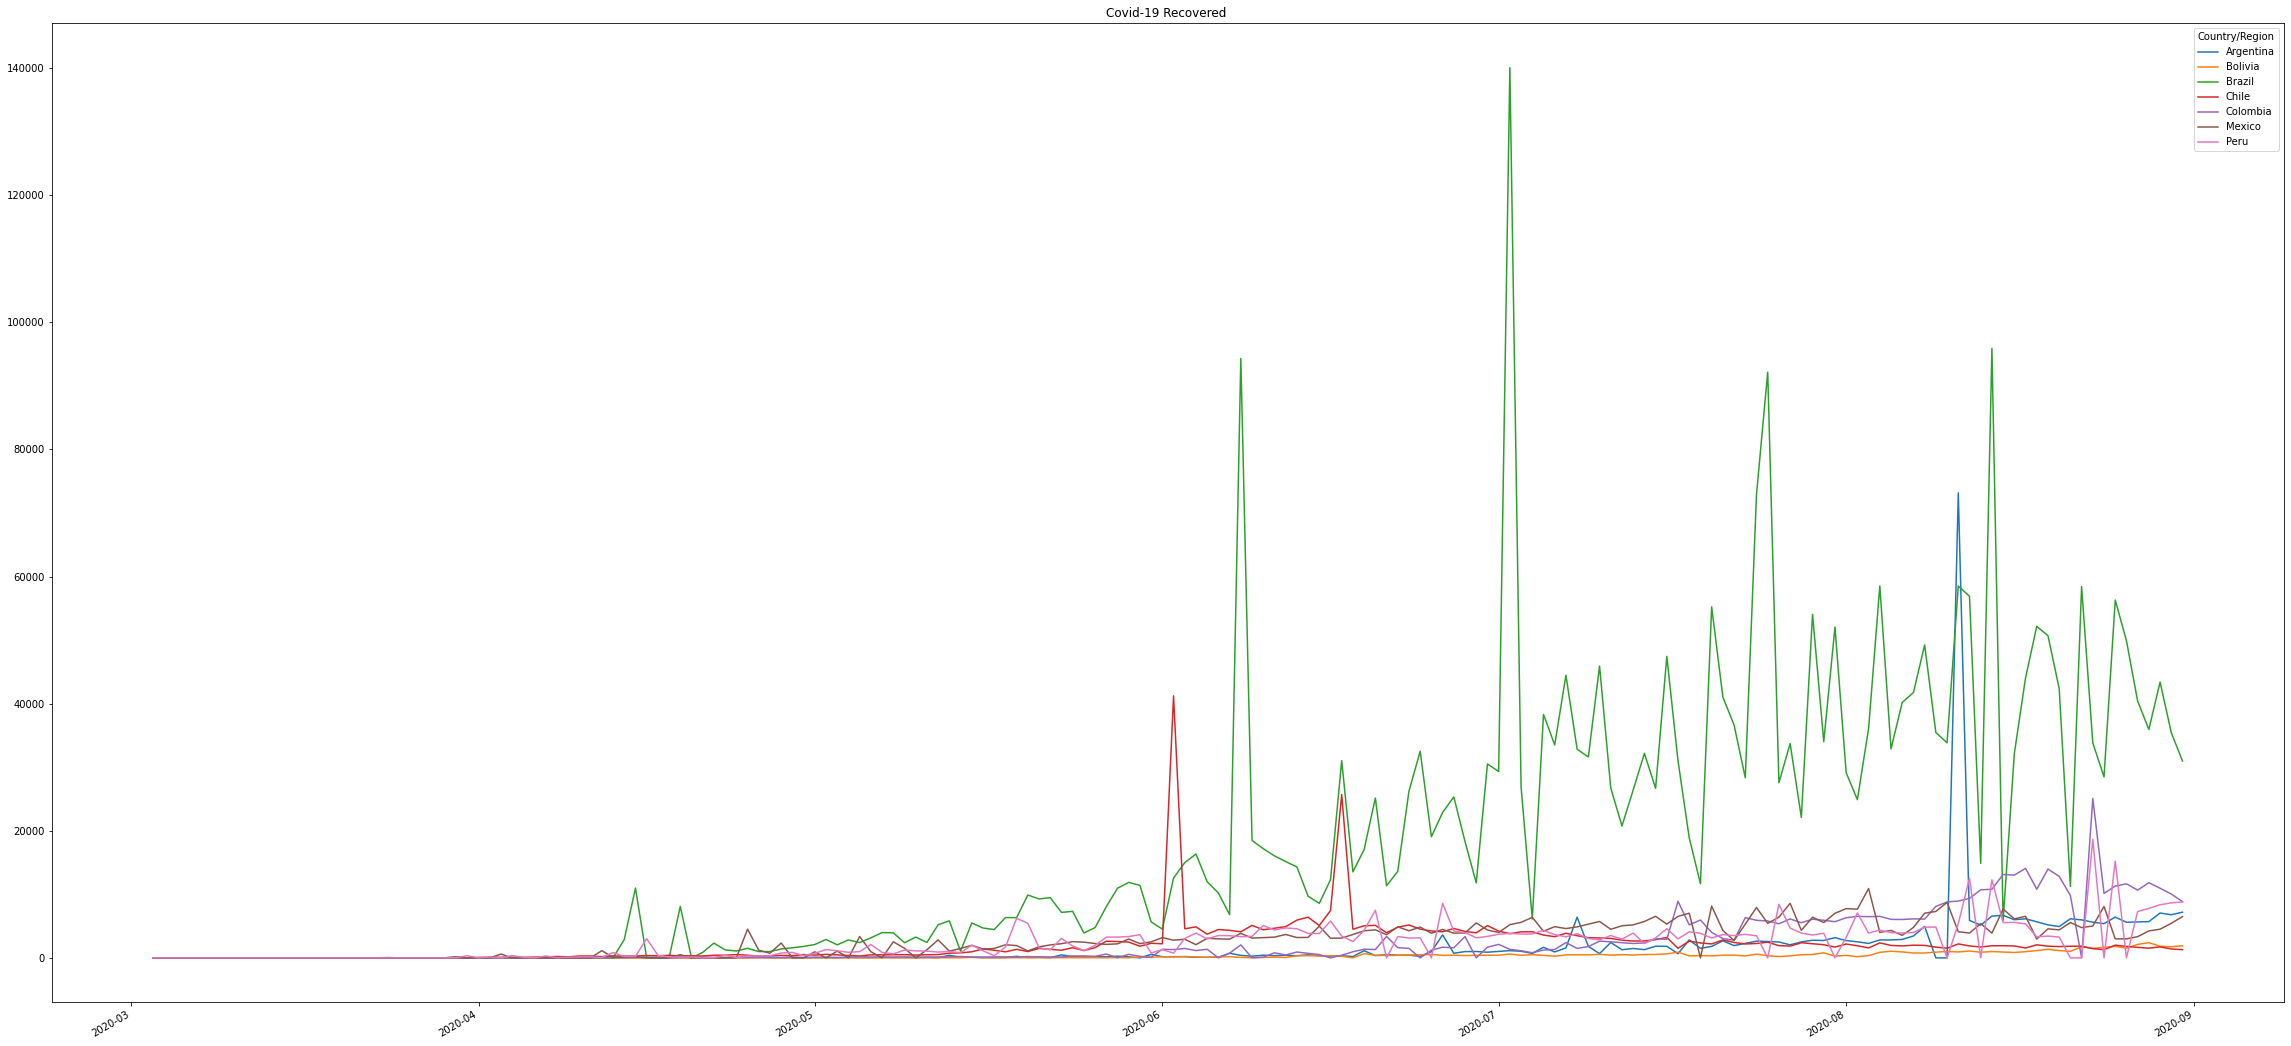

In [39]:
new_recovered_df.transpose().plot(kind='line', title='Covid-19 Recovered ', 
                                  logy=False)

## Calculate death rate based on all cases (recovered, deaths, still with Covid-19)

In [40]:
death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country/Region
Argentina    0.020731
Bolivia      0.043114
Brazil       0.031057
Chile        0.027419
Colombia     0.031966
Mexico       0.107435
Peru         0.044483
Name: 2020-08-31 00:00:00, dtype: float64

## Calculate death rate based on number of recovered patients plus deaths

In [41]:
death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] / \
                          (selected_recovered_df.iloc[:,-1] + \
                           selected_deaths_df.iloc[:,-1])
death_rate_vs_recovered

Country/Region
Argentina    0.027949
Bolivia      0.076824
Brazil       0.035806
Chile        0.028568
Colombia     0.041038
Mexico       0.114895
Peru         0.059449
Name: 2020-08-31 00:00:00, dtype: float64

## Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

In [42]:
# divide new cases from last four days with new cases from previous four days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4]) \
                  / (new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7] \
                   + new_confirmed_df.iloc[:,-8])
reproduction_df

Country/Region
Argentina    0.981777
Bolivia      0.871608
Brazil       0.943917
Chile        1.184403
Colombia     0.810138
Mexico       0.994734
Peru         1.200625
dtype: float64